# How to draw error bands

We show two ways to compute 1-sigma bands around a fitted curve.

Whether the curve describes a probability density (from a maximum-likelihood fit) or an expectation (from a least-squares fit) does not matter, the procedure is the same. We demonstrate this on an unbinned extended maximum-likelihood fit of a Gaussian.

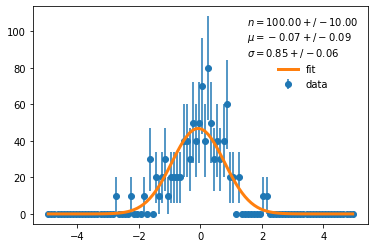

In [1]:
import numpy as np
from numba_stats import norm
from iminuit import Minuit
from iminuit.cost import ExtendedUnbinnedNLL
import matplotlib.pyplot as plt

# generate toy sample
rng = np.random.default_rng(1)
x = rng.normal(size=100)

# bin it
w, xe = np.histogram(x, bins=100, range=(-5, 5))

# compute bin-wise density estimates
werr = w ** 0.5
cx = 0.5 * (xe[1:] + xe[:-1])
dx = np.diff(xe)
d = w / dx
derr = werr / dx 


# define model and cost function
def model(x, par):
    return par[0], par[0] * norm.pdf(x, par[1], par[2])

cost = ExtendedUnbinnedNLL(x, model)

# fit the model
m = Minuit(cost, (1, 0, 1))
m.migrad()
m.hesse()

# plot everything
plt.errorbar(cx, d, derr, fmt="o", label="data", zorder=0)

plt.plot(cx, model(cx, m.values)[1], lw=3,
         label="fit")
plt.legend(frameon=False,
           title=f"$n = {m.values[0]:.2f} +/- {m.errors[0]:.2f}$\n"
                 f"$\mu = {m.values[1]:.2f} +/- {m.errors[1]:.2f}$\n"
                 f"$\sigma = {m.values[2]:.2f} +/- {m.errors[2]:.2f}$");

We want to understand how uncertain the Gaussian curve is. Thus we want to draw a 1-sigma error band around the curve, which approximates the 68 % confidence interval.

## With error propagation

The uncertainty is quantified in form of the covariance matrix of the fitted parameters. We can use [error propagation](https://en.wikipedia.org/wiki/Propagation_of_uncertainty) to obtain the uncertainty of the curve,

$$
C' = J \, C \, J^T,
$$

where $C$ is the covariance matrix of the input vector, $C'$ is the covariance matrix of the output vector and $J$ is the matrix of first derivatives of the mapping function between input and output. The mapping in this case is the curve, $\vec y = f(\vec{x}; \vec{p})$, regarded as a function of $\vec{p}$ and not of $\vec{x}$, which is fixed. The function maps from $\vec{p}$ to $\vec{y}$ and the Jacobi matrix is made from elements

$$
J_{ik} = \frac{\partial y_i}{\partial p_k}.
$$

To compute the derivatives one can sometimes use [Sympy](https://www.sympy.org/en/index.html) or an auto-differentiation tool like [JAX](https://jax.readthedocs.io/en/latest/) if the function permits it, but in general they need to be computed numerically. The function `iminuit.util.propagate` does just that and the whole propagation.

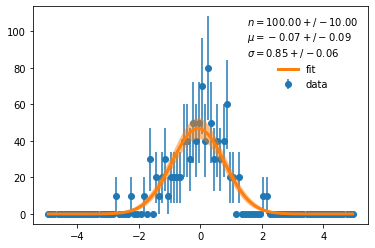

In [2]:
from iminuit.util import propagate

# run error propagation
y, ycov = propagate(lambda p: model(cx, p)[1], m.values, m.covariance)

# plot everything
plt.errorbar(cx, d, derr, fmt="o", label="data", zorder=0)

plt.plot(cx, y, lw=3, label="fit")

# draw 1 sigma error band
yerr_prop = np.diag(ycov) ** 0.5
plt.fill_between(cx, y - yerr_prop, y + yerr_prop, facecolor="C1", alpha=0.5)

plt.legend(frameon=False,
           title=f"$n = {m.values[0]:.2f} +/- {m.errors[0]:.2f}$\n"
                 f"$\mu = {m.values[1]:.2f} +/- {m.errors[1]:.2f}$\n"
                 f"$\sigma = {m.values[2]:.2f} +/- {m.errors[2]:.2f}$");

Error propagation is relatively fast.

In [3]:
%%timeit -r 1 -n 1000
propagate(lambda p: model(cx, p)[1], m.values, m.covariance)

807 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)


## With a parametric bootstrap

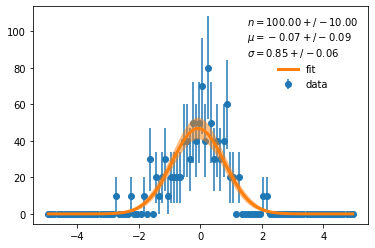

In [4]:
rng = np.random.default_rng(1)

# generate set of bootstrapped parameters
par_b = rng.multivariate_normal(m.values, m.covariance, size=1000)

# compute bootstrapped curves
y_b = [model(cx, p)[1] for p in par_b]
yerr_boot = np.std(y_b, axis=0)

# plot everything
plt.errorbar(cx, d, derr, fmt="o", label="data", zorder=0)

plt.plot(cx, y, lw=3, label="fit")

# draw 1 sigma error band
plt.fill_between(cx, y - yerr_boot, y + yerr_boot, facecolor="C1", alpha=0.5)

plt.legend(frameon=False,
           title=f"$n = {m.values[0]:.2f} +/- {m.errors[0]:.2f}$\n"
                 f"$\mu = {m.values[1]:.2f} +/- {m.errors[1]:.2f}$\n"
                 f"$\sigma = {m.values[2]:.2f} +/- {m.errors[2]:.2f}$");

The result is visually indistinguishable from before, as it should be. If you worry about deviations between the two methods, read on.

Bootstrapping is comparably slow. In this example, computing the band from 1000 samples is an order of magnitude slower than error propagation.

In [5]:
%%timeit -r 1 -n 100
rng = np.random.default_rng(1)
par_b = rng.multivariate_normal(m.values, m.covariance, size=1000)
y_b = [model(cx, p)[1] for p in par_b]
np.std(y_b, axis=0)

11.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 100 loops each)


However, the calculation time scales linearly with the number of samples. One can simply draw fewer samples if the additional uncertainty is acceptable. If we draw only 50 samples, the computational cost is comparable to error propagation.

In [6]:
%%timeit -r 1 -n 1000
rng = np.random.default_rng(1)
par_b = rng.multivariate_normal(m.values, m.covariance, size=50)
y_b = [model(cx, p)[1] for p in par_b]
np.std(y_b, axis=0)

808 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)


Let's see how the result looks, whether it deviates noticably.

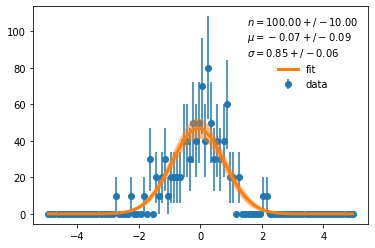

In [7]:
# compute bootstrapped curves with 50 samples
par_b = rng.multivariate_normal(m.values, m.covariance, size=50)
y_b = [model(cx, p)[1] for p in par_b]
yerr_boot_50 = np.std(y_b, axis=0)

# plot everything
plt.errorbar(cx, d, derr, fmt="o", label="data", zorder=0)

plt.plot(cx, y, lw=3, label="fit")

# draw 1 sigma error band
plt.fill_between(cx, y - yerr_boot_50, y + yerr_boot_50, facecolor="C1", alpha=0.5)

plt.legend(frameon=False,
           title=f"$n = {m.values[0]:.2f} +/- {m.errors[0]:.2f}$\n"
                 f"$\mu = {m.values[1]:.2f} +/- {m.errors[1]:.2f}$\n"
                 f"$\sigma = {m.values[2]:.2f} +/- {m.errors[2]:.2f}$");

No, the result is still visually indistinguishable. This suggests that 50 samples can be enough for plotting, which brings the computational cost of the bootstrap on par with error propagation.

Numerically, the three error bands differ at the 10 % level in the central region (expected relative error is $50^{-1/2} \approx 0.14$). The eye cannot pickup these differences, but they are there. The curves differ more in the tails, which is not visible in linear scale, but noticable in log-scale.

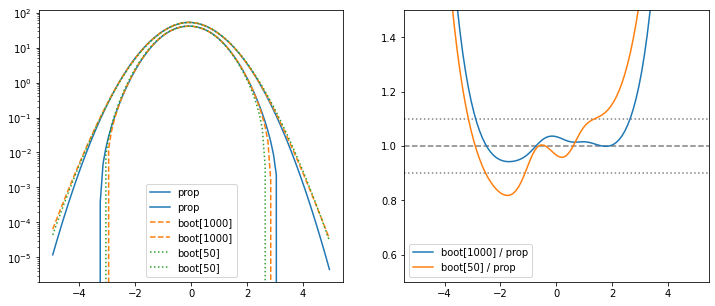

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

plt.sca(ax[0])
plt.plot(cx, y - yerr_prop, "-C0", label="prop")
plt.plot(cx, y + yerr_prop, "-C0", label="prop")
plt.plot(cx, y - yerr_boot, "--C1", label="boot[1000]")
plt.plot(cx, y + yerr_boot, "--C1", label="boot[1000]")
plt.plot(cx, y - yerr_boot_50, ":C2", label="boot[50]")
plt.plot(cx, y + yerr_boot_50, ":C2", label="boot[50]")
plt.legend()
plt.semilogy();

plt.sca(ax[1])
plt.plot(cx, yerr_boot / yerr_prop, label="boot[1000] / prop")
plt.plot(cx, yerr_boot_50 / yerr_prop, label="boot[50] / prop")
plt.legend()
plt.axhline(1, ls="--", color="0.5", zorder=0)
for delta in (-0.1, 0.1):
    plt.axhline(1 + delta, ls=":", color="0.5", zorder=0)
plt.ylim(0.5, 1.5);

We see that the bootstrapped bands are a bit wider in the tails. This is caused by non-linearities that are neglected in error propagation.

## Which is better? Error propagation or bootstrap?

There is no clear-cut answer. At the visual level, both methods are usually fine (even with small number of bootstrap samples). Which calculation is more accurate depends on details of the problem. Fortunately, the sources of error are orthogonal for both methods, so each method can be used to check the other.

* The bootstrap error is caused by sampling. It can be reduced by drawing more samples, the relative error is proportional to $N^{-1/2}$.
* The propagation error is caused by errors in the Jacobian and by the error of using a first-order Taylor series in the computation.